<a href="https://colab.research.google.com/github/ML-Bioinfo-CEITEC/ECCB2021/blob/main/04_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial is building on top of [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning) keras tutorial and [The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions](https://www.nature.com/articles/sdata2018161) dataset (downloaded from [HAM10000 ImageNet-style dataset](https://www.kaggle.com/umangjpatel/ham10000-imagenet-style-dataset) kaggle dataset). Only small subset of original data is used: class `df` with 115 images, class `vasc` with 142 images and class `akiec` with 327 images.

## Setup


In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from keras import regularizers
import keras

## Data preparation

In [13]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
from pathlib import Path

_URL = 'https://github.com/ML-Bioinfo-CEITEC/ECCB2021/raw/main/data/HAM10000/'
PATH = Path('/content/datasets/HAM10000')
for split in ['train', 'val']:
  Path(PATH / split).mkdir(parents=True, exist_ok=True)
  for zip_file in ['akiec.zip', 'df.zip', 'vasc.zip']:
    with urlopen(_URL + split + '/' + zip_file) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(PATH / split)

In [14]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (100, 100)

In [15]:
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 466 files belonging to 3 classes.


In [16]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 118 files belonging to 3 classes.


Show the first nine images and labels from the training set:

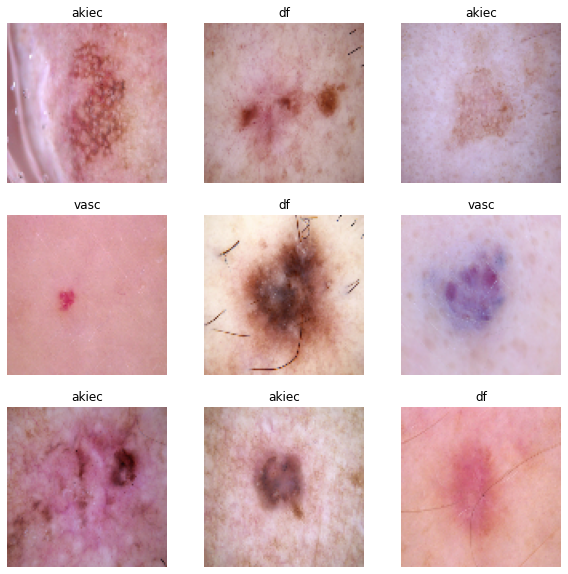

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data augmentation


When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call model.fit. They are inactive when the model is used in inference mode in model.evaulate or model.fit.

Let's repeatedly apply these layers to the same image and see the result.

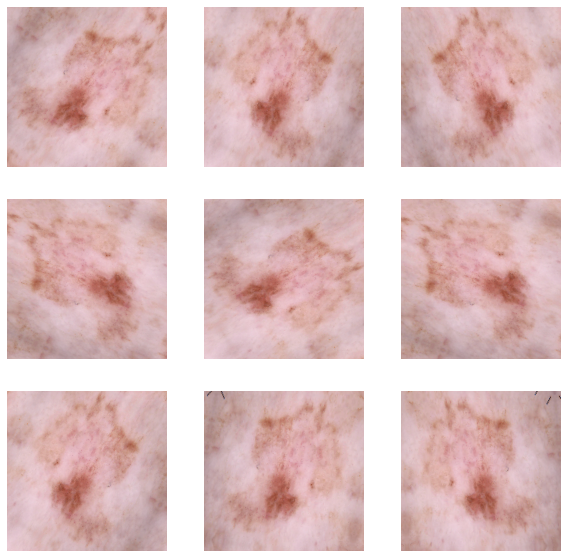

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Create the base model from the pre-trained model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

This feature extractor converts each 160x160x3 image into a 5x5x2048 block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 80, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 2048-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
NUM_LABELS = 3
prediction_layer = tf.keras.layers.Dense(NUM_LABELS, activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In a moment, you will download tf.keras.applications.ResNet50 for use as your base model. This model expects pixel values in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 160, 160, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

## Train the model

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
15/15 [==============================] - 53s 3s/step - loss: 1.8982 - accuracy: 0.2983 - val_loss: 1.4551 - val_accuracy: 0.3390
Epoch 2/10
15/15 [==============================] - 50s 3s/step - loss: 1.4012 - accuracy: 0.4249 - val_loss: 1.1943 - val_accuracy: 0.4661
Epoch 3/10
15/15 [==============================] - 49s 3s/step - loss: 1.2202 - accuracy: 0.5043 - val_loss: 1.0780 - val_accuracy: 0.5339
Epoch 4/10
15/15 [==============================] - 49s 3s/step - loss: 1.1195 - accuracy: 0.5579 - val_loss: 0.9859 - val_accuracy: 0.5593
Epoch 5/10
15/15 [==============================] - 49s 3s/step - loss: 1.0626 - accuracy: 0.6009 - val_loss: 0.9107 - val_accuracy: 0.6186
Epoch 6/10
15/15 [==============================] - 49s 3s/step - loss: 0.9866 - accuracy: 0.6052 - val_loss: 0.8417 - val_accuracy: 0.6525
Epoch 7/10
15/15 [==============================] - 49s 3s/step - loss: 0.9336 - accuracy: 0.6309 - val_loss: 0.7869 - val_accuracy: 0.7203
Epoch 8/10
15/15 [==